# GraphSAGE
## Máster Oficial: Big Data Science


https://www.unav.edu/web/instituto-de-ciencia-de-los-datos-e-inteligencia-artificial<br>

Autor: Darian Horacio Grass Boada

# ¿Qué tienen en común UberEats y Pinterest?

Ambos utilizan GraphSAGE para alimentar sus sistemas de recomendación a una escala masiva: millones y miles de millones de nodos y aristas.

- 🖼️ Pinterest desarrolló su propia versión llamada PinSAGE para recomendar las imágenes (pines) más relevantes a sus usuarios. Su grafo tiene 18 mil millones de conexiones y tres mil millones de nodos.
- 🍽️ UberEats también informó que utiliza una versión modificada de GraphSAGE para sugerir platos, restaurantes y cocinas. UberEats afirma apoyar a más de 600,000 restaurantes y 66 millones de usuarios. Mientras tanto, sigue recomendándome tacos que me dieron intoxicación alimentaria.

En este tutorial, utilizaremos un conjunto de datos con 20k nodos en lugar de miles de millones porque Google Colab no puede manejar nuestras ambiciones. Nos apegaremos a la arquitectura original de GraphSAGE, pero las variantes anteriores también aportan características emocionantes que discutiremos.

In [ ]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 47.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Dataset

# El Conjunto de Datos PubMed

PubMed es parte del conjunto de datos Planetoid (licencia MIT). Aquí hay un resumen rápido:

- Contiene 19,717 publicaciones científicas sobre diabetes de la base de datos de PubMed
- Las características de los nodos son vectores de palabras ponderados por TF-IDF con 500 dimensiones, que es una forma eficiente de resumir documentos sin transformadores
- La tarea es bastante sencilla ya que es una clasificación multiclase con tres categorías: diabetes mellitus experimental, diabetes mellitus tipo 1 y diabetes mellitus tipo 2

Carguemos el conjunto de datos e imprimamos alguna información sobre el grafo.

In [ ]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# Análisis del Conjunto de Datos PubMed

Como podemos ver, PubMed tiene un número increíblemente bajo de nodos de entrenamiento en comparación con todo el grafo. Solo hay 60 muestras para aprender a clasificar los 1000 nodos de prueba.

A pesar de este desafío, las GNN logran obtener altos niveles de precisión. Aquí está la tabla de líderes de las técnicas conocidas (se puede encontrar un benchmark más exhaustivo en PapersWithCode):

| Modelo | 📝PubMed (precisión) |
| --- | --- |
| Perceptrón Multicapa | 71.4% |
| Red Convolutiva de Grafos | 79.0% ± 0.3% |
| Red de Atención de Grafos | 79.0% ± 0.3% |
| GraphSAGE | ??? |

No pude encontrar ningún resultado para GraphSAGE en PubMed con esta configuración específica (60 nodos de entrenamiento, 1000 nodos de prueba), por lo que no espero una gran precisión. Pero otra métrica puede ser igual de relevante al trabajar con grafos grandes: el tiempo de entrenamiento.

# Mini-batching

/usr/local/lib/python3.10/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


Subgraph 0: Data(x=[394, 500], edge_index=[2, 457], y=[394], train_mask=[394], val_mask=[394], test_mask=[394], n_id=[394], e_id=[457], input_id=[16], batch_size=16)
Subgraph 1: Data(x=[239, 500], edge_index=[2, 293], y=[239], train_mask=[239], val_mask=[239], test_mask=[239], n_id=[239], e_id=[293], input_id=[16], batch_size=16)
Subgraph 2: Data(x=[286, 500], edge_index=[2, 328], y=[286], train_mask=[286], val_mask=[286], test_mask=[286], n_id=[286], e_id=[328], input_id=[16], batch_size=16)
Subgraph 3: Data(x=[194, 500], edge_index=[2, 229], y=[194], train_mask=[194], val_mask=[194], test_mask=[194], n_id=[194], e_id=[229], input_id=[12], batch_size=12)


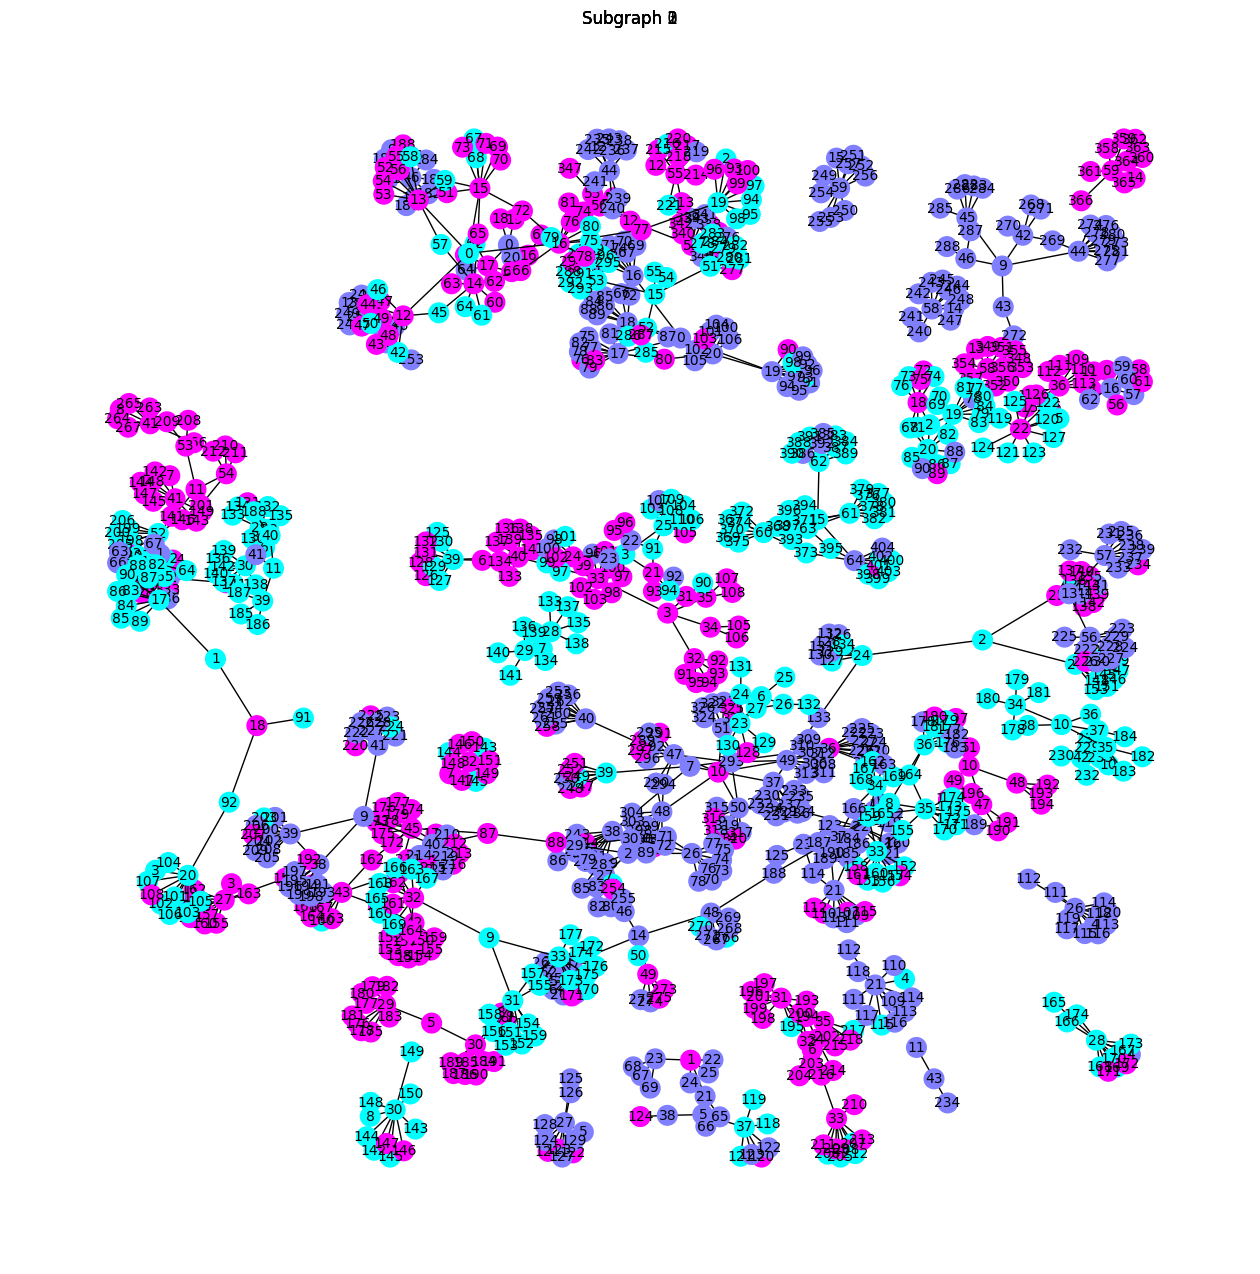

In [ ]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, ['221', '222', '223', '224'])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot()
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

# Plot node degrees

# Creación de Subgrafos

Hemos creado cuatro subgrafos de varios tamaños. Esto nos permite procesarlos en paralelo y son más fáciles de ajustar en una GPU ya que son más pequeños.

El número de vecinos es un parámetro importante ya que podar nuestro grafo elimina mucha información. ¿Cuánto exactamente? Bueno, bastante. Podemos visualizar este efecto mirando los grados de los nodos (número de vecinos).

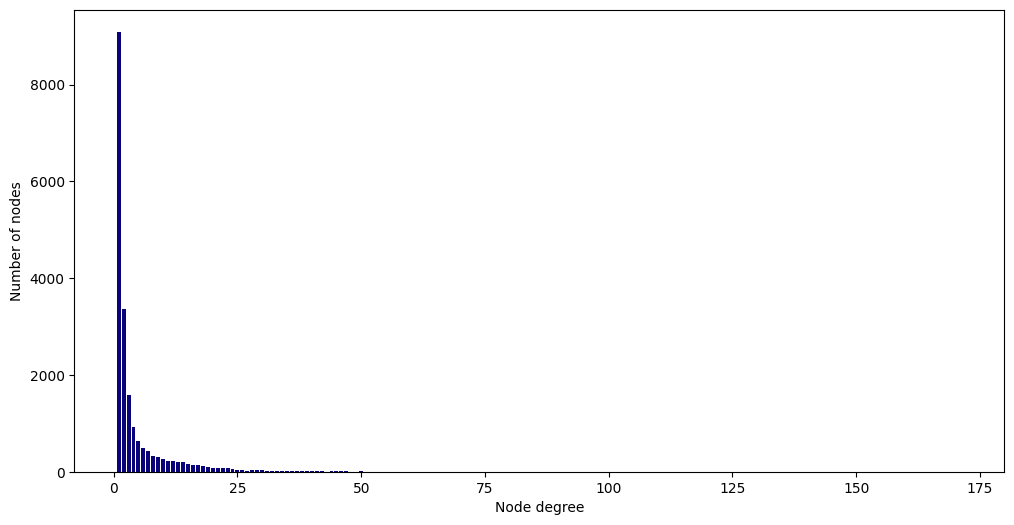

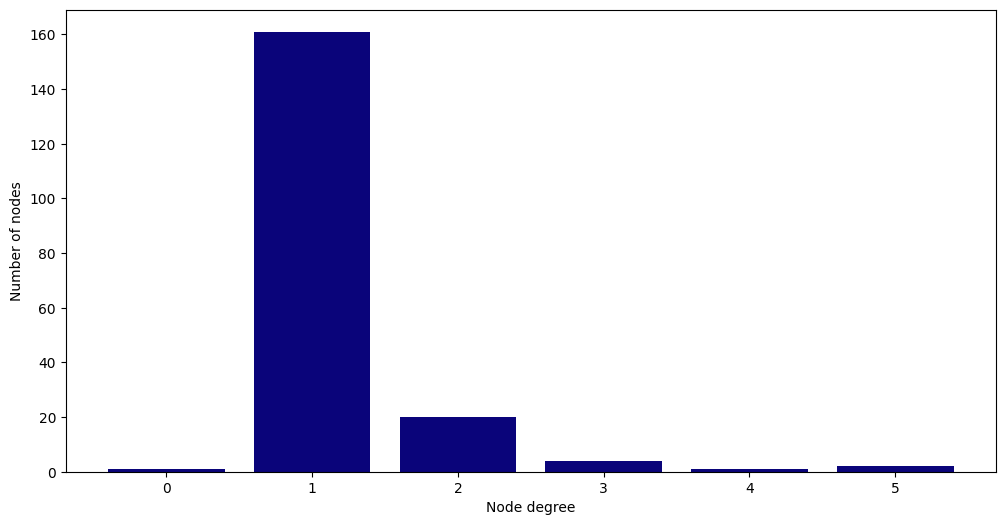

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

# Distribución de Grados de Nodos

El primer gráfico muestra la distribución original de los grados de los nodos, y el segundo muestra la distribución que obtenemos después de la muestra de vecinos. En este ejemplo, elegimos considerar solo cinco vecinos, que es mucho menor que el valor máximo original. Es importante recordar este compromiso al hablar de GraphSAGE.

PinSAGE propone otra solución. En lugar de muestrear vecinos, PinSAGE simula caminatas aleatorias para cada nodo, lo que captura una mejor representación de sus vecindarios. Luego, selecciona un número predefinido de vecinos con los recuentos de visitas más altos. Esta técnica permite a PinSAGE considerar la importancia de cada vecino mientras controla el tamaño del grafo de cálculo.

# Implement GraphSage vs. GAT vs. GCN

# Implementación de GraphSAGE en PyTorch Geometric

Podemos implementar fácilmente una arquitectura GraphSAGE en PyTorch Geometric con la capa SAGEConv.

Creemos una red con dos capas SAGEConv:

- La primera utiliza ReLU como función de activación y una capa de dropout;
- La segunda directamente produce los embeddings de los nodos.

Como estamos tratando con una tarea de clasificación multiclase, utilizaremos la pérdida de entropía cruzada como nuestra función de pérdida. También agregué una regularización L2 de 0.0005 por si acaso.

Para ver los beneficios de GraphSAGE, comparemoslo con un GCN y un GAT sin ningún muestreo.

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GraphSAGE

# Proceso de Entrenamiento con GraphSAGE

Con GraphSAGE, iteramos a través de lotes (nuestros cuatro subgrafos) creados por el proceso de muestreo de vecinos. La forma en que calculamos la precisión y la pérdida de validación también es diferente debido a eso.

In [ ]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 0.318 | Train Acc:  33.18% | Val Loss: 1.11 | Val Acc: 33.13%
Epoch  10 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 69.57%
Epoch  20 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.40 | Val Acc: 86.93%
Epoch  30 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.68 | Val Acc: 69.67%
Epoch  40 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 0.46 | Val Acc: 91.67%
Epoch  50 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 0.53 | Val Acc: 77.62%
Epoch  60 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 87.26%
Epoch  70 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 72.22%
Epoch  80 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 0.51 | Val Acc: 73.04%
Epoch  90 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.51 | Val Acc: 72.92%
Epoch 100 | Train Loss: 0.001 | Train Acc: 100.00

# Train GCN

In [ ]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)
Epoch   0 | Train Loss: 1.102 | Train Acc:  25.00% | Val Loss: 1.10 | Val Acc: 34.00%
Epoch  10 | Train Loss: 0.761 | Train Acc:  91.67% | Val Loss: 0.89 | Val Acc: 72.20%
Epoch  20 | Train Loss: 0.392 | Train Acc:  93.33% | Val Loss: 0.68 | Val Acc: 76.20%
Epoch  30 | Train Loss: 0.218 | Train Acc:  96.67% | Val Loss: 0.63 | Val Acc: 75.80%
Epoch  40 | Train Loss: 0.119 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.20%
Epoch  50 | Train Loss: 0.103 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 76.00%
Epoch  60 | Train Loss: 0.104 | Train Acc:  98.33% | Val Loss: 0.59 | Val Acc: 77.40%
Epoch  70 | Train Loss: 0.088 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 76.60%
Epoch  80 | Train Loss: 0.103 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 76.40%
Epoch  90 | Train Loss: 0.064 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 74.80%
Epoch 100 | Train Loss: 0.080 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 75

# Train GAT

In [ ]:
%%time
# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 64, heads=8)
  (gat2): GATv2Conv(512, 3, heads=8)
)
Epoch   0 | Train Loss: 3.182 | Train Acc:  10.00% | Val Loss: 3.17 | Val Acc: 9.20%
Epoch  10 | Train Loss: 0.720 | Train Acc:  86.67% | Val Loss: 0.88 | Val Acc: 72.60%
Epoch  20 | Train Loss: 0.344 | Train Acc:  96.67% | Val Loss: 0.66 | Val Acc: 74.80%
Epoch  30 | Train Loss: 0.179 | Train Acc:  96.67% | Val Loss: 0.60 | Val Acc: 76.40%
Epoch  40 | Train Loss: 0.106 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 77.80%
Epoch  50 | Train Loss: 0.069 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 77.40%
Epoch  60 | Train Loss: 0.080 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.40%
Epoch  70 | Train Loss: 0.065 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 78.40%
Epoch  80 | Train Loss: 0.063 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.40%
Epoch  90 | Train Loss: 0.061 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.00%
Epoch 100 | Train Loss: 0.052 | Train Acc: 100.00% | Val Lo

# Comparación de Modelos

Los tres modelos obtienen resultados similares en términos de precisión. Esperamos que el GAT funcione mejor porque su mecanismo de agregación es más matizado, pero no siempre es el caso.

La verdadera diferencia es el tiempo de entrenamiento: ¡GraphSAGE es 88 veces más rápido que el GAT y cuatro veces más rápido que el GCN en este ejemplo!

Este es el verdadero beneficio de GraphSAGE. Si bien pierde mucha información al podar el grafo con el muestreo de vecinos, mejora enormemente la escalabilidad. A su vez, puede conducir a la construcción de grafos más grandes que pueden mejorar la precisión.

# Variantes de GraphSAGE

GraphSAGE es un marco popular con muchos sabores.

En este ejemplo, hemos utilizado GraphSAGE en un entorno transductivo. Enmascaramos la información sobre los nodos de prueba durante el entrenamiento, pero no ocultamos su presencia en la matriz de adyacencia. Por el contrario, en un entorno inductivo, el conjunto de prueba nunca se encuentra durante el entrenamiento.

Esta diferencia es esencial: un modelo inductivo puede calcular embeddings para nodos que nunca se han visto antes. Por otro lado, un modelo transductivo tiene que ser reentrenado, lo que puede llegar a ser computacionalmente costoso rápidamente. Gracias al muestreo de vecinos, GraphSAGE está diseñado para ser un modelo inductivo: no requiere ver a cada vecino para calcular un embedding.

Además de estos dos entornos, GraphSAGE puede ser entrenado de manera no supervisada. En este caso, no podemos usar la pérdida de entropía cruzada. Tenemos que diseñar una función de pérdida que obligue a los nodos que están cerca en el grafo original a permanecer cerca entre sí en el espacio de embedding. A la inversa, la misma función debe asegurar que los nodos distantes en el grafo deben tener representaciones distantes en el espacio de embedding. Esta es la pérdida que se presenta en el paper de GraphSAGE.

PinSAGE y el GraphSAGE modificado de UberEats también son ligeramente diferentes ya que estamos tratando con sistemas de recomendación. Su objetivo es clasificar correctamente los elementos más relevantes (pins, restaurantes) para cada usuario. No solo queremos obtener los embeddings más cercanos, sino que también tenemos que producir los mejores rankings posibles. Es por eso que estos sistemas se entrenan de manera no supervisada pero con otra función de pérdida: una pérdida de ranking de margen máximo.

# Conclusión

GraphSAGE es una arquitectura increíblemente rápida que puede procesar grandes grafos. Puede que no sea tan preciso como un GCN o un GAT, pero es un modelo esencial para manejar grandes cantidades de datos. Ofrece esta velocidad gracias a una combinación inteligente de muestreo de vecinos y agregación rápida. En este artículo,

- Exploramos un nuevo conjunto de datos con PubMed, que tiene casi diez veces más conexiones que el anterior (CiteSeer)
- Explicamos la idea detrás del muestreo de vecinos, que solo considera un número predefinido de vecinos aleatorios en cada salto
- Vimos los tres agregadores presentados en el paper de GraphSAGE y nos enfocamos en el agregador de media
- Comparamos tres modelos (GraphSAGE, GAT y GCN) en términos de precisión y tiempo de entrenamiento